# TD learning; the agent that can see

# Remember to check the number of samples for alpha and beta

now I'm gonna add numbers to the model. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import confusion_matrix
np.random.seed(42)
from joblib import Parallel, delayed
import matplotlib.tri as tri
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
from scipy.interpolate import RBFInterpolator
import matplotlib.ticker as mticker


In [2]:
folder_path = 'data_risk_added'
dataframes = [pd.read_excel(os.path.join(folder_path, file)) for file in os.listdir(folder_path) if file.endswith('.xlsx')]

n_participant = len(dataframes)
print(f"there are {n_participant} participants.")


output_dir = "12_RL_agent_TDlearn_output"
os.makedirs(output_dir, exist_ok=True)
dataframes[0]


there are 31 participants.


,arrowRT,distribution,interTrialInterval,outcome,myCard,yourCard,spaceRT,totalReward,trialIndex,trialType,choice,block,timeoutRepeat,risk
0,2609,uniform,789,lose,4,2,1335,9.5,0,response,arrowdown,1,0,0.375
1,597,uniform,853,win,9,4,1407,10,1,response,arrowup,1,0,0.000
2,188,uniform,904,win,4,7,1504,10.5,2,response,arrowdown,1,0,0.375
3,423,uniform,916,win,2,4,1434,11,3,response,arrowdown,1,0,0.125
4,549,uniform,806,win,5,7,1287,11.5,4,response,arrowdown,1,0,0.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,761,high,913,win,7,8,1382,80,125,response,arrowdown,4,0,0.447
273,596,low,921,win,4,3,1318,80.5,83,response,arrowup,4,0,0.385
274,414,low,950,win,2,7,1335,81,77,response,arrowdown,4,0,0.243
275,1371,uniform,842,win,6,4,1615,81.5,35,response,arrowup,4,0,0.375


# policy initilization for the model
now I need to find the prior policy amounts. for that I am going to put the percentage of downarrow and up arrow for each number 

In [3]:
df_combined = pd.concat(dataframes, ignore_index=True)

df_combined = df_combined[df_combined['outcome'].str.lower() != 'na']  



cards_sorted = sorted(df_combined["myCard"].unique())
choice_sorted = sorted(df_combined["choice"].unique())


card_idx = {card: i for i, card in enumerate(cards_sorted)}
choice_idx = {choice: i for i, choice in enumerate(choice_sorted)}


matrix_2d = np.zeros((len(cards_sorted), len(choice_sorted)))


for _, row in df_combined.iterrows():
    i = card_idx[row["myCard"]]-1
    k = choice_idx[row["choice"]]
    matrix_2d[i, k] += 1  


total_per_card_dist = matrix_2d.sum(axis=1, keepdims=True)

# compute percentages, avoiding division by zero
with np.errstate(divide='ignore', invalid='ignore'):
    percentage_matrix = np.divide(matrix_2d, total_per_card_dist, where=total_per_card_dist != 0)

# convert to a DataFrame for easy visualization
percentage_list = []
for i, card in enumerate(cards_sorted):
    for k, choice in enumerate(choice_sorted):
        percentage_list.append({
            "myCard": card,
            "choice": choice,
            "percentage": percentage_matrix[i, k]
        })

df_percentages = pd.DataFrame(percentage_list)
df_percentages

,myCard,choice,percentage
0,1,arrowdown,0.943011
1,1,arrowup,0.056989
2,2,arrowdown,0.857595
3,2,arrowup,0.142405
4,3,arrowdown,0.709677
5,3,arrowup,0.290323
6,4,arrowdown,0.499466
7,4,arrowup,0.500534
8,5,arrowdown,0.337953
9,5,arrowup,0.662047


In [4]:
np.shape(percentage_matrix)
# percentage_matrix

(9, 2)

In [5]:
actions = { "arrowdown": 0, "arrowup": 1}
card_numbers = list(range(1, 10))

policy_table = percentage_matrix 

Q_table_init = np.random.normal(0, 0.1, (len(card_numbers), len(actions)))
# having a q-table based on the policies
Q_table_init = policy_table * np.mean(Q_table_init) 
Q_table = Q_table_init.copy()

#############################################################################################
# having a q-table that starts with 0! this was not a good initilization so i changed it.
# Q_table = np.zeros((len(distributions_map), len(actions)))  # 3 distributions × 2 actions
#############################################################################################

print("policy: \n",np.shape(policy_table))
print("\n Q_table: \n",np.shape(Q_table))


policy: 
 (9, 2)

 Q_table: 
 (9, 2)


In [6]:
def softmax(Q_values, beta):    
    # this part subtracts the maximum q-value in each row it means each state to improve numerical stability.
    # because exxponentials of large numbers can lead to overflow errors, so shifting q-values avoids this problem.
    
    Q_shifted = Q_values - np.max(Q_values, axis=1, keepdims=True)
    exps = np.exp(beta * Q_shifted)
    sums = np.sum(exps, axis=1, keepdims=True)
    new_probs = exps / sums

    return new_probs



def train_rescorla_wagner(df, alpha, beta, Q_init=None):
    if Q_init is None:
        Q_init = Q_table.copy()
    Q_values = Q_init.copy()
    q_value_pairs = []
    choices = []
    predicted_probs = []
    card_numbers = []
    
    for _, row in df.iterrows():
        action = actions[row["choice"]] 
        card_number = row["myCard"]-1 # since I'm using this as an index! I need to do -1 to make the 1 to 9 cards come to 0 to 8
        reward = 0.5 if row["outcome"] == "win" else -0.5
        
        probs = softmax(Q_values, beta)
        predicted_probs.append(probs[card_number][action])
        
        prediction_error = reward - Q_values[card_number][action]
        Q_values[card_number][action] += alpha * prediction_error
        
        q_value_pairs.append(Q_values.copy())
        choices.append(action)
        card_numbers.append(card_number)
        

    return np.array(q_value_pairs), np.array(choices), np.array(predicted_probs), np.array(card_numbers)


# this is for the sake of parallel computing
def compute_log_likelihood(alpha, beta, df_all, Q_table):
    Q_init_participant = Q_table.copy()
    q_values, choices, predicted_probs, card_numbers = train_rescorla_wagner(df_all, alpha, beta, Q_init=Q_init_participant)
    
    predicted_probs = np.clip(predicted_probs, 1e-6, 1)  # prevent log(0)
    log_likelihood = np.sum(np.log(predicted_probs))
    
    return (alpha, beta, log_likelihood)


saved: 12_RL_agent_TDlearn_output\plot_0.pdf
saved: 12_RL_agent_TDlearn_output\plot_1.pdf
saved: 12_RL_agent_TDlearn_output\plot_2.pdf
saved: 12_RL_agent_TDlearn_output\plot_3.pdf
saved: 12_RL_agent_TDlearn_output\plot_4.pdf


KeyboardInterrupt: 

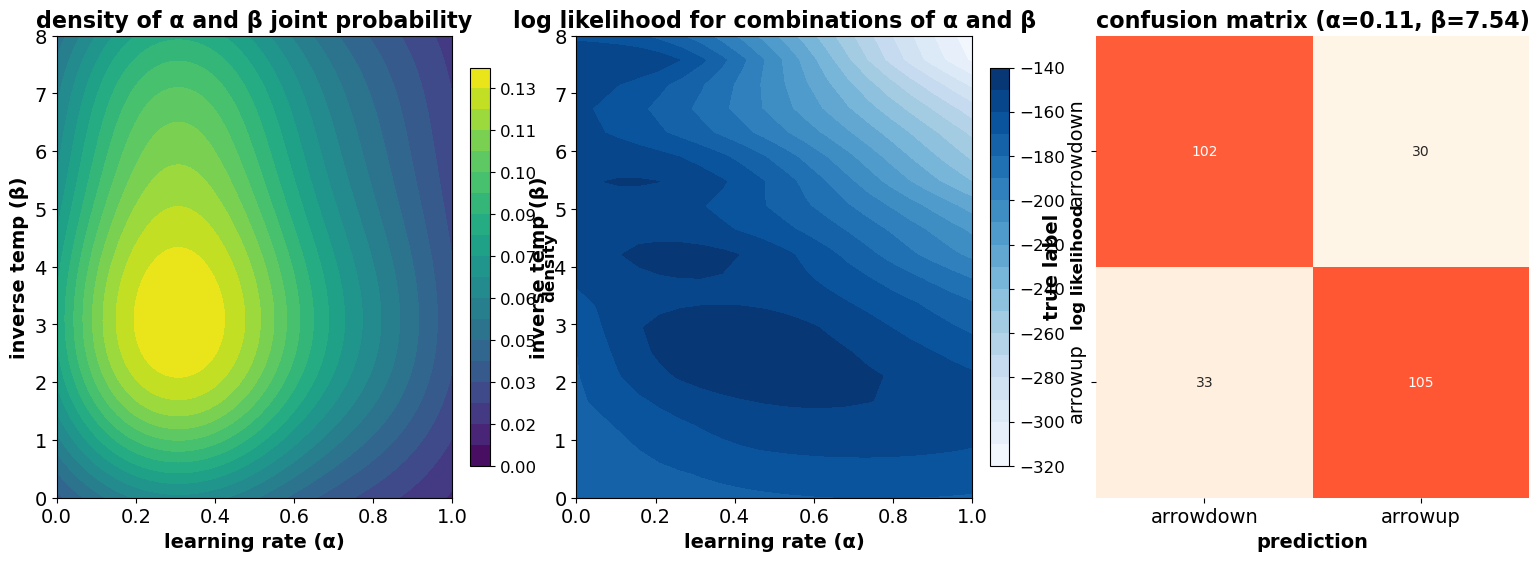

In [7]:
BIC_models = []
for idx, df_all in enumerate(dataframes):
    Q_init_participant = Q_table.copy()
    
    df_all = df_all[df_all['outcome'].str.lower() != 'na']  

    num_of_samples = 10
    # num_of_samples = 1000
    alpha_min = 0
    alpha_max = 1
    beta_min = 0
    beta_max  = 8
    alpha_samples = np.random.uniform(alpha_min, alpha_max, num_of_samples) 
    beta_samples = np.random.uniform(beta_min, beta_max, num_of_samples)  


    best_alpha, best_beta = None, None
    best_log_likelihood = -np.inf


    alpha_beta_log_likelihood = {}

    results = Parallel(n_jobs=-1)(delayed(compute_log_likelihood)(alpha, beta, df_all, Q_table) 
                                for alpha in alpha_samples for beta in beta_samples)


# finding alpha beta in parallel way
    alpha_beta_log_likelihood = {}
    best_log_likelihood = -np.inf
    best_alpha, best_beta = None, None

    for alpha, beta, log_likelihood in results:
        alpha_beta_log_likelihood[(alpha, beta)] = log_likelihood
        if log_likelihood > best_log_likelihood:
            best_log_likelihood = log_likelihood
            best_alpha, best_beta = alpha, beta


    results_df = pd.DataFrame(alpha_beta_log_likelihood.keys(), columns=["alpha", "beta"])
    results_df["log_likelihood"] = alpha_beta_log_likelihood.values()

    #  model prediction 
    
    q_values, choices, predicted_probs, card_numbers = train_rescorla_wagner(df_all, best_alpha, best_beta, Q_init=Q_init_participant)
    # now we need to find out the predicted choices of the model:
    

    predicted_choices = []

    for trial in range(len(card_numbers)):  
        if q_values[trial][card_numbers[trial]][actions["arrowup"]] > q_values[trial][card_numbers[trial]][actions["arrowdown"]]:
            predicted_choices.append(1)
        else:
            predicted_choices.append(0)

    
    
    # confusion matrix
    conf_matrix = confusion_matrix(choices, predicted_choices)
    
    # bayes information criterion
    n_trials = len(df_all)
    k = 2  # number of free parameters: alpha and beta
    BIC = k * np.log(n_trials) - 2 * best_log_likelihood
    
    BIC_models.append(BIC)
    ###########################################################################################
    ## visulization

    fig, axes = plt.subplots(1, 3, figsize=(19, 6))

    plots_smooth_level = 20

    # Density Plot (KDE)
    sns.kdeplot(
        x=results_df["alpha"], 
        y=results_df["beta"], 
        fill=True, 
        cmap="viridis", 
        ax=axes[0], 
        bw_adjust=1.8,  # Increase for smoother density
        levels=plots_smooth_level,  # More contour levels
        thresh=0  # Ensure density is plotted across all values
    )
    mappable = axes[0].collections[0]
    cbar = fig.colorbar(mappable, ax=axes[0], label="density", fraction=0.046, pad=0.04)  # Adjust size
    cbar.ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))  # 2 decimal places
    cbar.ax.set_ylabel("density", fontsize=12, fontweight='bold')
    cbar.ax.tick_params(labelsize=12)

    axes[0].set_xlim(alpha_min, alpha_max)
    axes[0].set_ylim(beta_min, beta_max)
    axes[0].set_xlabel("learning rate (α)", fontsize=14, fontweight='bold')
    axes[0].set_ylabel("inverse temp (β)", fontsize=14, fontweight='bold')
    axes[0].set_title("density of α and β joint probability", fontsize=16, fontweight='bold')
    axes[0].tick_params(axis='both', labelsize=14)

    # Log Likelihood Contour Plot
    alpha_extrapolated = np.linspace(alpha_min, alpha_max, plots_smooth_level)
    beta_extrapolated = np.linspace(beta_min, beta_max, plots_smooth_level)
    xi, yi = np.meshgrid(alpha_extrapolated, beta_extrapolated)

    # Using RBFInterpolator for smoother interpolation and extrapolation
    rbf_interpolator = RBFInterpolator(
        np.column_stack((results_df["alpha"], results_df["beta"])), 
        results_df["log_likelihood"], 
        smoothing=0.2  
    )
    zi = rbf_interpolator(np.column_stack((xi.ravel(), yi.ravel()))).reshape(xi.shape)
    contour = axes[1].contourf(xi, yi, zi, levels=plots_smooth_level, cmap="Blues")
    cbar = plt.colorbar(contour, ax=axes[1], label="log likelihood", fraction=0.046, pad=0.04)  # Adjust size
    cbar.ax.set_ylabel("log likelihood", fontsize=12, fontweight='bold')
    cbar.ax.tick_params(labelsize=12)

    axes[1].set_xlabel("learning rate (α)", fontsize=14, fontweight='bold')
    axes[1].set_ylabel("inverse temp (β)", fontsize=14, fontweight='bold')
    axes[1].set_title("log likelihood for combinations of α and β", fontsize=16, fontweight='bold')
    axes[1].tick_params(axis='both', labelsize=14)

    # Confusion Matrix
    heatmap_cmap_color = mcolors.LinearSegmentedColormap.from_list("warm_red", ["#fff5e6", "#ff5733"])
    sns.heatmap(
        conf_matrix, annot=True, fmt="d", cmap=heatmap_cmap_color,
        xticklabels=["arrowdown", "arrowup"], 
        yticklabels=["arrowdown", "arrowup"], 
        ax=axes[2], 
        cbar=False
    )

    axes[2].set_xlabel("prediction", fontsize=14, fontweight='bold')
    axes[2].set_ylabel("true label", fontsize=14, fontweight='bold')
    axes[2].set_title(f"confusion matrix (α={best_alpha:.2f}, β={best_beta:.2f})", fontsize=16, fontweight='bold')
    axes[2].tick_params(axis='both', labelsize=14)






    plt.tight_layout(rect=[0, 0, 1, 0.9]) 
    fig.suptitle(f'participant {idx}', fontsize=18, fontweight='bold', y=0.93)

    filename = os.path.join(output_dir, f"plot_{idx}.pdf")
    plt.savefig(filename, format='pdf')
    plt.close(fig)

    print(f"saved: {filename}")

# saving BIC_models to compare models:
file_path_BIC = os.path.join(output_dir, "BIC_models_see_numbers.txt")

with open(file_path_BIC, "w") as file:
    for bic in BIC_models:
        file.write(f"{bic}\n")

print(f"BIC values saved to {file_path_BIC}")
